<a href="https://colab.research.google.com/github/calmrocks/master-machine-learning-engineer/blob/main/modules/generative-ai/materials/notebooks/llm_benchmark_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Foundation Models Comparison

This notebook compares different LLM foundation models across various aspects including:
- Response quality
- Performance metrics
- Resource usage
- Practical considerations

We'll test models from different providers:
- OpenAI (GPT-3.5, GPT-4)
- Anthropic (Claude-2)
- Meta (Llama-2)
- Mistral AI (Mistral-7B)

### Setup Required Libraries
Import necessary packages for model interaction, data processing, and visualization


In [ ]:
!pip install anthropic


In [20]:
import openai
import anthropic
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict
import json
import seaborn

### Model Configuration
Define the models to compare and their configurations

In [36]:
class ModelConfig:
    def __init__(self, name, api_key=None):
        self.name = name
        self.api_key = api_key

models_to_compare = {
    "gpt-3.5-turbo": {"type": "api", "provider": "openai"},
    "claude-2": {"type": "api", "provider": "anthropic"},
    "microsoft/phi-2": {"type": "local", "provider": "huggingface"},
    "facebook/opt-125m": {"type": "local", "provider": "huggingface"},
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0": {"type": "local", "provider": "huggingface"}
}

### Test Cases Definition
Define various test cases across different categories to evaluate model performance


In [22]:
test_cases = [
    {
        "category": "General Knowledge",
        "prompts": [
            "What is the capital of France?",
            "Explain quantum computing in simple terms",
        ]
    },
    {
        "category": "Code Generation",
        "prompts": [
            "Write a Python function to check if a string is palindrome",
            "Create a simple REST API using Flask",
        ]
    },
    {
        "category": "Creative Writing",
        "prompts": [
            "Write a short story about a time traveler",
            "Create a poem about artificial intelligence",
        ]
    }
]

### Evaluation Metrics
Define functions to evaluate model responses based on different criteria


In [23]:
def evaluate_response(response: str, criteria: Dict) -> Dict:
    """
    Evaluate model response based on different criteria
    """
    results = {
        "length": len(response),
        "response_time": criteria.get("response_time", 0),
        # Add more metrics as needed
    }
    return results

### Model Wrapper Class
Create a wrapper class to handle different types of models consistently


In [37]:
class LLMWrapper:
    def __init__(self, model_name: str, model_config: Dict):
        self.model_name = model_name
        self.model_config = model_config
        self.setup_model()

    def setup_model(self):
        if self.model_config["type"] == "api":
            if self.model_config["provider"] == "openai":
                self.client = openai.OpenAI()
            elif self.model_config["provider"] == "anthropic":
                self.client = anthropic.Anthropic(api_key=self.model_config["api_key"])
        else:
            try:
                # Add device placement for better memory management
                device = "cuda" if torch.cuda.is_available() else "cpu"
                print(f"Loading {self.model_name} on {device}")

                # Load with lower precision for memory efficiency
                self.tokenizer = AutoTokenizer.from_pretrained(
                    self.model_name,
                    token=False  # Explicitly state we're not using token
                )
                self.model = AutoModelForCausalLM.from_pretrained(
                    self.model_name,
                    token=False,
                    torch_dtype=torch.float16,  # Use float16 for memory efficiency
                    low_cpu_mem_usage=True,
                    device_map="auto"
                )
                print(f"Successfully loaded {self.model_name}")
            except Exception as e:
                print(f"Error loading model {self.model_name}: {e}")
                raise

    def generate(self, prompt: str) -> Dict:
        start_time = time.time()

        try:
            if self.model_config["type"] == "api":
                if self.model_config["provider"] == "openai":
                    response = self.client.chat.completions.create(
                        model=self.model_name,
                        messages=[{"role": "user", "content": prompt}]
                    )
                    result = response.choices[0].message.content

                elif self.model_config["provider"] == "anthropic":
                    response = self.client.messages.create(
                        model=self.model_name,
                        messages=[{"role": "user", "content": prompt}]
                    )
                    result = response.content
            else:
                # Local model inference
                inputs = self.tokenizer(prompt, return_tensors="pt")
                outputs = self.model.generate(**inputs)
                result = self.tokenizer.decode(outputs[0])

            end_time = time.time()

            return {
                "response": result,
                "response_time": end_time - start_time,
                "status": "success"
            }

        except Exception as e:
            return {
                "response": str(e),
                "response_time": time.time() - start_time,
                "status": "error"
            }

### Model Comparison Class
Define class to run comparisons across all models and generate reports


In [59]:
class ModelComparison:
    def __init__(self, models_config: Dict, openai_key: str, anthropic_key: str):
        # Store API keys
        self.openai_key = openai_key
        self.anthropic_key = anthropic_key

        # Initialize models with appropriate API keys
        self.models = {}
        for name, config in models_config.items():
            if config["provider"] == "openai":
                config["api_key"] = self.openai_key
            elif config["provider"] == "anthropic":
                config["api_key"] = self.anthropic_key
            self.models[name] = LLMWrapper(name, config)

        self.results = []

    def run_comparison(self, test_cases: List[Dict]):
        for case in test_cases:
            for prompt in case["prompts"]:
                for model_name, model in self.models.items():
                    result = model.generate(prompt)
                    evaluation = evaluate_response(
                        result["response"],
                        {"response_time": result["response_time"]}
                    )

                    self.results.append({
                        "model": model_name,
                        "category": case["category"],
                        "prompt": prompt,
                        "response": result["response"],
                        "metrics": evaluation
                    })

    def generate_report(self):
        # Convert the nested results into a flat DataFrame structure
        flat_results = []
        for result in self.results:
            flat_results.append({
                'model': result['model'],
                'category': result['category'],
                'prompt': result['prompt'],
                'response': result['response'],
                'response_time': result['metrics']['response_time'],  # Flatten metrics
                'response_length': result['metrics']['length']  # Flatten metrics
            })
        return pd.DataFrame(flat_results)

    def plot_comparisons(self):
        """Plot comparison visualizations with error handling"""
        try:
            # Generate the report DataFrame
            df = self.generate_report()

            if df.empty:
                print("No data available to plot.")
                return

            # Import required libraries
            import matplotlib.pyplot as plt
            import seaborn as sns

            # Create figure with larger size
            plt.figure(figsize=(15, 6))

            # Response Time Plot
            plt.subplot(1, 2, 1)
            sns.boxplot(data=df, x='model', y='response_time')
            plt.xticks(rotation=45, ha='right')
            plt.title('Response Time by Model')
            plt.xlabel('Model')
            plt.ylabel('Response Time (seconds)')

            # Response Length Plot
            plt.subplot(1, 2, 2)
            sns.barplot(data=df, x='model', y='response_length')
            plt.xticks(rotation=45, ha='right')
            plt.title('Average Response Length by Model')
            plt.xlabel('Model')
            plt.ylabel('Response Length (characters)')

            # Adjust layout to prevent label cutoff
            plt.tight_layout()

            # Show the plot
            plt.show()

        except Exception as e:
            print(f"Error creating plots: {e}")
            print("\nDebug information:")
            print(f"Results available: {len(self.results)}")
            if self.results:
                print("Sample result structure:", self.results[0].keys())

### Provide API Keys
To use this notebook, you'll need API keys from OpenAI and Anthropic. Here's how to get them:

1. OpenAI API Key:
   - Go to https://platform.openai.com/
   - Sign up or log in
   - Navigate to Settings > API Keys
   - Click "Create new secret key"
   - Copy the key (you won't be able to see it again)

2. Anthropic API Key:
   - Go to https://console.anthropic.com/
   - Sign up or log in
   - Navigate to API Keys section
   - Click "Create Key"
   - Copy the key (starts with 'sk-ant-')

⚠️ Security Notes:
- Never share your API keys
- Keep track of usage/costs
- Keys can be revoked and regenerated if compromised
- Consider setting up usage limits in the provider dashboards


In [26]:
import getpass
import os

# Get API keys securely
print("Enter your OpenAI API Key (input will be hidden):")
openai_key = getpass.getpass()
os.environ['OPENAI_API_KEY'] = openai_key

print("Enter your Anthropic API Key (input will be hidden):")
anthropic_key = getpass.getpass()

# Set the keys and verify format
if openai_key and anthropic_key:
    if not openai_key.startswith('sk-'):
        raise ValueError("Invalid OpenAI API key format")
    if not anthropic_key.startswith('sk-ant-'):
        raise ValueError("Invalid Anthropic API key format")
    obsidian://open?vault=Denny&file=GDPR
    # Set the keys
    openai.api_key = openai_key
    anthropic.api_key = anthropic_key
    print("✅ API keys successfully configured!")
else:
    print("⚠️ Please enter both API keys to proceed")

Enter your OpenAI API Key (input will be hidden):
··········
Enter your Anthropic API Key (input will be hidden):
··········
✅ API keys successfully configured!


In [ ]:
# Create comparison with API keys
comparison = ModelComparison(
    models_config=models_to_compare,
    openai_key=openai.api_key,
    anthropic_key=anthropic.api_key
)

# Run comparison
comparison.run_comparison(test_cases)

### Generate and Display Results
Create reports and visualizations from the comparison results


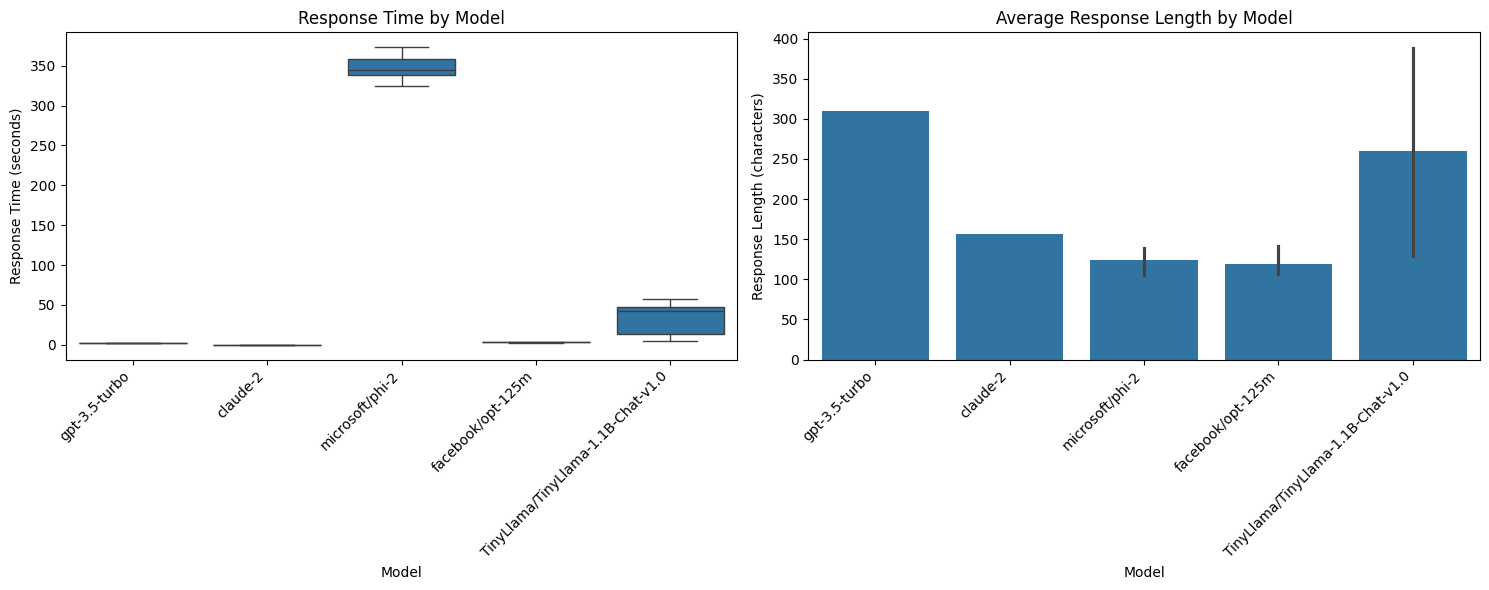

In [65]:
# Generate and display results
comparison.generate_report()
comparison.plot_comparisons()